In [1]:
import pandas as pd

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
data = pd.concat((train, test), sort=False)

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature extraction

In [2]:
data['is_male'] = data['Sex'].apply(lambda x: x == 'male')

In [3]:
data['Embarked'] = pd.Categorical(data['Embarked'])

In [4]:
data['family_name'] = data['Name'].apply(lambda x: x.split(',')[0])
data = data.join(data['family_name'].value_counts().rename('family_name_count'), on='family_name')

In [5]:
data['title'] = data['Name'].apply(lambda x: x.split(',')[1].split('.')[0])
data['title'] = pd.Categorical(data['title'])

In [6]:
data['cabin_letter'] = data['Cabin'].apply(lambda x: x[0] if isinstance(x, str) else 'no cabin')
data['cabin_letter'] = pd.Categorical(data['cabin_letter'])

In [7]:
from cat2vec import Cat2Vec
cat_cols = ['Sex','Pclass','SibSp','Parch']
c2v = Cat2Vec(data,cat_cols)
c2v.fit()
c2v.transform()
data = pd.concat([data.reset_index(drop=True),c2v.cat2vec],axis=1)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,is_male,family_name,family_name_count,title,cabin_letter,cat2vec_0,cat2vec_1,cat2vec_2,cat2vec_3
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,True,Braund,2,Mr,no cabin,-0.168737,-0.041022,0.074808,0.297041
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,False,Cumings,2,Mrs,C,-0.137108,-0.060576,0.059669,0.255659
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,False,Heikkinen,1,Miss,no cabin,-0.146753,-0.105121,0.097193,0.363608
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,False,Futrelle,2,Mrs,C,-0.137108,-0.060576,0.059669,0.255659
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,True,Allen,2,Mr,no cabin,-0.150936,-0.084962,0.069433,0.347255
5,6,0.0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,...,Q,True,Moran,3,Mr,no cabin,-0.150936,-0.084962,0.069433,0.347255
6,7,0.0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,...,S,True,McCarthy,2,Mr,E,-0.123490,-0.084356,0.026532,0.289519
7,8,0.0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,...,S,True,Palsson,5,Master,no cabin,-0.113362,-0.059878,0.049174,0.278591
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,...,S,False,Johnson,6,Mrs,no cabin,-0.171932,-0.136925,0.113474,0.359399
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,...,C,False,Nasser,2,Mrs,no cabin,-0.118419,-0.023516,0.072999,0.266783


## Learning

Prepare the datasets.

In [8]:
is_train = data['Survived'].notnull()
to_drop = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'family_name']

X_train = data[is_train].drop(to_drop + ['Survived'], axis='columns')
y_train = data[is_train]['Survived']
X_test = data[~is_train].drop(to_drop + ['Survived'], axis='columns')
submission = data[~is_train]['PassengerId'].to_frame()

Do some sanity checks.

In [9]:
assert len(X_train) == 891
assert len(y_train) == 891
assert len(X_test) == 418
assert len(submission) == 418
assert len(X_train.columns) == len(X_test.columns)

Find the optimal number of boosting rounds through cross-validation.

In [10]:
import time
import numpy as np
import lightgbm as lgbm
from sklearn import model_selection


# https://lightgbm.readthedocs.io/en/latest/Parameters.html
params = {
    'application': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_threads': 8,
    'num_leaves': 2 ** 4,
    'min_data_per_group': 30,
    'max_cat_threshold': 32,
    'max_cat_to_onehot': 4,
    'cat_smooth': 5,
    'cat_l2': 10,
    'max_bin': 255,
    'min_data_in_bin': 3,
    'scale_pos_weight': 1,
    'min_data_in_leaf': 30,
    'learning_rate': 0.08,
    'feature_fraction': 1,
    'feature_fraction_seed': 42,
    'bagging_fraction': 1,
    'bagging_seed': 42,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'verbosity': 2
}

# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.Dataset
train_set = lgbm.Dataset(X_train, y_train)

# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.cv
tic = time.time()
hist = lgbm.cv(
    params=params,
    train_set=train_set,
    num_boost_round=100,
    folds=None,
    nfold=5,
    stratified=True,
    shuffle=True,
    metrics=None,
    fobj=None,
    feval=None,
    init_model=None,
    feature_name='auto',
    categorical_feature='auto',
    early_stopping_rounds=30,
    fpreproc=None,
    verbose_eval=False,
    show_stdv=True,
    seed=0,
    callbacks=None
)
toc = time.time()

best_round = np.argmax(hist['auc-mean'])
print('Best AUC: {:.5f} (±{:.5f})'.format(hist['auc-mean'][best_round], hist['auc-stdv'][best_round]))
print('Best round: {}'.format(best_round))
print('Training took {} seconds'.format(toc - tic))

Best AUC: 0.88094 (±0.01530)
Best round: 26
Training took 0.13296771049499512 seconds


Plot the validation score against the number of rounds.

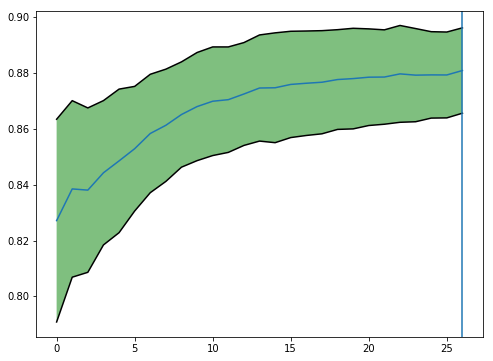

In [11]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 6))

lower = [m - s for m, s in zip(hist['auc-mean'], hist['auc-stdv'])]
upper = [m + s for m, s in zip(hist['auc-mean'], hist['auc-stdv'])]
ax.plot(hist['auc-mean']);
ax.plot(lower, color='black');
ax.plot(upper, color='black');
ax.fill_between(x=list(range(len(lower))), y1=lower, y2=upper, facecolor='green', alpha=0.5);
ax.axvline(x=best_round);

Train on all of the training set.

In [12]:
# https://lightgbm.readthedocs.io/en/latest/Python-API.html#lightgbm.train
model = lgbm.train(
    params=params,
    train_set=train_set,
    num_boost_round=best_round,
    valid_names=('train'),
    verbose_eval=10
)

Display feature importance.

In [13]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'gain': model.feature_importance('gain'),
    'split': model.feature_importance('split')
}).set_index('feature')

fi.sort_values('gain', ascending=False)

,gain,split
feature,,
is_male,1480.113098,12
Pclass,488.872375,25
Fare,433.814122,105
Age,389.197832,121
title,328.382540,14
cabin_letter,91.639720,13
SibSp,82.795851,8
family_name_count,57.678506,27
Embarked,55.418470,13


Make predictions.

In [ ]:
submission['Survived'] = model.predict(X_test)
submission.head()